<img class="ms edge" alt="KPMG logo" src="https://assets.kpmg/content/dam/kpmg/xx/images/kpmg-logo.jpg">

by Raul Nugis, Sept 2019

# Example of scraping market data from a commercial site and creating ML model to predict prices of used cars

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import requests
    
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Scrape Business Data from the internet and vizualize resuls

In the following excercise we will scrape data from a car sales portal and have an overview about the market for a randomly chosen used car model.
We will be doing a little of descriptive statistics with this data and then create ML model to predict prices of used cars based on this market data.

#### First, function "get_cars" is created to get web page data

Web page contents can be downloaded with 'requests' library like this: 


<STRONG>contents = requests.get(link1)</STRONG>

Then, the function "get_cars" can be used to parse web page data into a DataFrame

<STRONG>first_page = get_cars(mark, contents)</STRONG>

In [2]:
def get_cars(mark, contents):

    '''Retrieves car data from web page contents
    requires pandas, bs4, re and returns DataFrame with market data
    '''
    
    import pandas as pd
    from bs4 import BeautifulSoup as bs
    import re
    import numpy as np

    # DataFrames setup

    data_columns = ['No', 'Engine', 'kW', 'KM', 'Type', 'Drive', 'Year', 'Fuel', 'Transmission', 'Price']
    car_data = pd.DataFrame(index = range(0,1))
    for column in data_columns:
        car_data[column] = 'Puudub'
    car_table = pd.DataFrame(columns = ['No','Engine','kW','KM','Type','Drive','Year','Fuel','Transmission','Price'])
    
    # Parse web contents
    
    try:
        soup = bs(contents.text, 'html.parser')
    except:
        print('Could not parse web contents')
        return car_table
    try:
        table = soup.find( "table", {"id":"usedVehiclesSearchResult"} )
        rows = table.findAll(lambda tag: tag.name=='tr')
    except:
        print('Did not find car table')
        return car_table

    # Car types

    types = ['sedaan',
             'luukpära',
             'universaal',
             'mahtuniversaal',
             'kupee',
             'kabriolett',
             'pikapp',
             'limusiin']

    drives = ['esivedu',
              'tagavedu',
              'nelikvedu']

    engine_re = re.escape(mark) + r'.*?(\d+\.{0,1}\d+) '
    kw_re = re.escape(mark) + r'.*?\d+\.{0,1}\d+.*?(\d+) kW'

    # Read table

    i = 0
    for row in rows[1:]:    
        year = engine = kw = fuel = transmission = km = type_= drive = price = 'Puudub'
        cols = row.find_all('td')

        cols = [x.text.strip() for x in cols]
        
        if len(cols) == 8:
            year = cols[3]
            fuel = cols[4]
            transmission = cols[5]
            price = cols[7]
            if price.find('\xa0')  >  -1:
                price = price.replace('\xa0', '')
                
            if cols[1].find(mark) > -1:
                try:
                    engine = re.search(engine_re, cols[1]).group(1)
                except:
                    pass
                try:
                    kw = re.search(kw_re, cols[1]).group(1)
                except:
                    pass

        extras = row.find_all('div')
        cols2 = [x.text.strip() for x in extras]

        if len(cols2) == 2:
            cols2_elements = cols2[0].split('\xa0')

            if len(cols2_elements) >= 3:

                if cols2_elements[2] == 'km':
                    km = str(cols2_elements[0]) + str(cols2_elements[1])
                if cols2_elements[1] == 'km':
                    km = str(cols2_elements[0])


            for element in cols2_elements:
                try:
                    location = types.index(element)
                    if location > -1:
                        type_ = types[location]
                except:
                    pass

            for element in cols2_elements:
                try:
                    location = drives.index(element)
                    if location > -1:
                        drive = drives[location]
                except:
                    pass

        # Saving to dataframe

        car_data['No'][0:1] = i
        car_data['Engine'][0:1] = engine
        car_data['kW'][0:1] = kw
        car_data['KM'][0:1] = km
        car_data['Type'][0:1] = type_
        car_data['Drive'][0:1] = drive
        car_data['Year'][0:1] = year
        car_data['Fuel'][0:1] = fuel
        car_data['Transmission'][0:1] = transmission
        car_data['Price'][0:1] = price

        car_table = car_table.append(car_data)
        i += 1
    
    message = str(i) + ' Downloaded ' + str(len(car_table)) + ' lines of car data for ' + mark
    print(message)
    
    # Preparing the DataFrame to make it easier to work with it later
    
    car_table = car_table.set_index('No')
    car_table['Price'] = car_table['Price'].str.replace(' sis. KM','')

    for column in car_table.columns:
        car_table[column] = car_table[column].replace({'Puudub' : np.nan, '' : np.nan})
    car_table = car_table.dropna(how='all')
    
    car_table = car_table.fillna(0)
    for column in ['kW', 'KM', 'Year', 'Price']:
        try:
            car_table[column] = car_table[column].astype('int')
        except:
            pass
    try:
        car_table['Engine'] = car_table['Engine'].astype('float')
    except:
        pass
        
    return car_table

These are the links (valid Sept 2019) to used cars' prices and the car mark is 'Toyota Avensis'

In [4]:
link1 = 'https://www.auto24.ee/kasutatud/nimekiri.php?bn=2&a=100&aj=&b=13&bw=15&ae=2&af=200&ag=0&ag=1&otsi=otsi'
link2 = 'https://www.auto24.ee/kasutatud/nimekiri.php?bn=2&a=100&b=13&bw=15&ae=2&af=200&ag=1&otsi=otsi&ak=200'
mark = 'Toyota Avensis'

We download the first page of used car prices from auto24, about 
Toyota Avensis

In [4]:
contents = requests.get(link1)

first_page = get_cars(mark, contents)
first_page.head()

201 Downloaded 201 lines of car data for Toyota Avensis


,Engine,kW,KM,Type,Drive,Year,Fuel,Transmission,Price
No,,,,,,,,,
0,1.6,81,219000,luukpära,esivedu,1999,B,M,699
1,1.8,81,260000,sedaan,esivedu,1999,B,M,990
2,2.0,85,0,universaal,esivedu,2003,D,M,1050
3,1.6,81,149000,sedaan,esivedu,2002,B,M,1199
4,2.2,130,0,universaal,esivedu,2005,0,0,1400


We download the second page of used car prices from auto24, about 
Toyota Avensis

In [5]:
contents = requests.get(link2)

second_page = get_cars(mark, contents)
second_page.head()

89 Downloaded 89 lines of car data for Toyota Avensis


,Engine,kW,KM,Type,Drive,Year,Fuel,Transmission,Price
No,,,,,,,,,
0,1.8,108,173940,sedaan,esivedu,2014,B,A,9950
1,1.6,82,120000,universaal,esivedu,2015,D,M,9950
2,1.8,108,0,0,0,2013,B,A,9990
3,1.8,108,123490,sedaan,esivedu,2012,B,A,9990
4,2.0,91,230300,universaal,esivedu,2014,D,M,9990


We join both pages into one DataFrame

In [6]:
df = first_page.append(second_page)
print('Scraped in all', len(df), 'car price data lines for', mark)

Scraped in all 289 car price data lines for Toyota Avensis


Now showing some statistics about the DataFrame (basically tabular data)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 0 to 88
Data columns (total 9 columns):
Engine          289 non-null float64
kW              289 non-null int32
KM              289 non-null int32
Type            289 non-null object
Drive           289 non-null object
Year            289 non-null int32
Fuel            289 non-null object
Transmission    289 non-null object
Price           289 non-null int32
dtypes: float64(1), int32(4), object(4)
memory usage: 18.1+ KB


In [8]:
df.describe()

,Engine,kW,KM,Year,Price
count,289.000000,289.000000,289.000000,289.000000,289.000000
mean,9.958478,111.692042,161642.993080,2010.553633,8263.913495
std,118.474770,111.329273,99944.602926,4.300928,5304.894292
min,1.600000,81.000000,0.000000,1999.000000,0.000000
25%,1.800000,95.000000,87000.000000,2007.000000,3800.000000
50%,2.000000,108.000000,173000.000000,2011.000000,7250.000000
75%,2.200000,110.000000,237800.000000,2014.000000,10900.000000
max,2013.000000,1987.000000,400810.000000,2019.000000,23990.000000


From the table above an average car has travelled 163K kilometres and costs 8K EUR. This is simple, but can be useful statistics!

Values in "Transmission" column

In [9]:
df['Transmission'].value_counts()

M    150
A    135
0      4
Name: Transmission, dtype: int64

A lot of cars have automatic gear box ('transmission' here is clearly wrong word)

Transfer data about kilometrages into ranges for easier visualization

In [10]:
d = {range(0,50000): 50000,
    range(50001,100000): 100000, 
     range(100001,150000): 150000,
     range(150001,200000): 200000,
    range(200001,250000): 250000,
     range(250000,500000): 500000}

df['KM_Ranges'] = df['KM'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
print('I split mileage into ranges like 0 - 50K, 50K - 100K .... now lets see statistics')
df['KM_Ranges'].value_counts()

I split mileage into ranges like 0 - 50K, 50K - 100K .... now lets see statistics


200000    68
50000     58
500000    57
250000    51
150000    37
100000    18
Name: KM_Ranges, dtype: int64

This is how mileage is distributed. Most frequent cars are 150K - 200K mileage


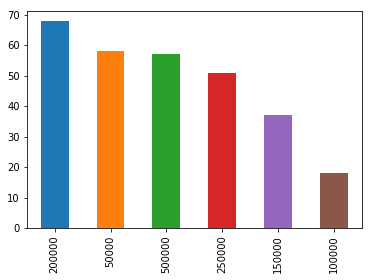

In [11]:
%matplotlib inline
print('This is how mileage is distributed. Most frequent cars are 150K - 200K mileage')
df['KM_Ranges'].value_counts().plot.bar()

Next will slice the DataFrame into smaller tables based on mileage ranges and visualize price - mileage stats

For Kilometrage of 50000 average price is 14272 and average year is 2014


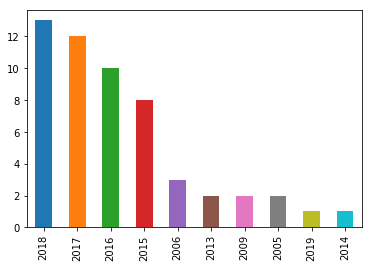

For Kilometrage of 100000 average price is 13487 and average year is 2014


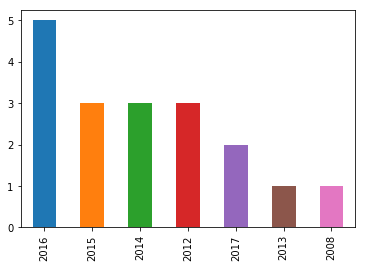

For Kilometrage of 150000 average price is 8804 and average year is 2011


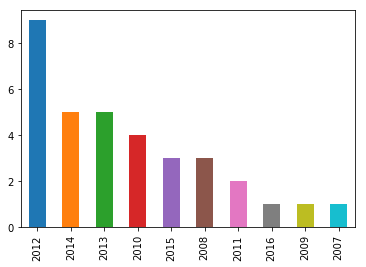

For Kilometrage of 200000 average price is 7340 and average year is 2010


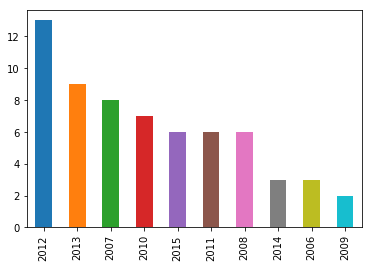

For Kilometrage of 250000 average price is 5634 and average year is 2008


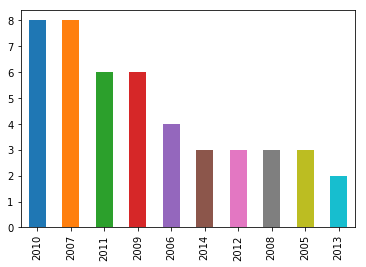

For Kilometrage of 500000 average price is 3603 and average year is 2006


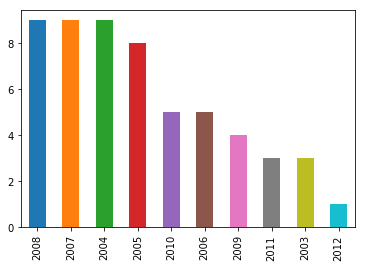

In [12]:
for km_range in sorted(list(df['KM_Ranges'].unique())):
    
    price_range = df[df['KM_Ranges'] == km_range]
    print('For Kilometrage of', km_range, 'average price is', 
          int(price_range['Price'].mean()),'and average year is',
          int(price_range['Year'].mean()))
    price_range['Year'].value_counts().iloc[0:10].plot.bar()
    plt.show()

There is also built-in function for creating ranges

In [13]:
df['Price_range'] = pd.cut(df['Price'], 25)

sorted(list(df['Price_range'].unique()))[0]

Interval(-23.99, 959.6, closed='right')

The next is similar printout of graph as before, the price ranges are automatically selected

For Kilometrage of 50000 average price is 14272 and average year is 2014


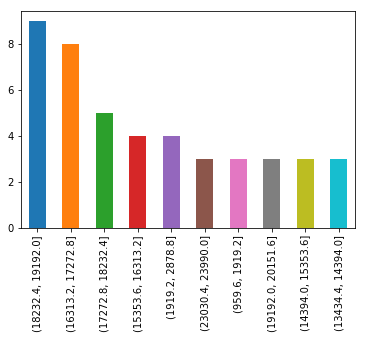

For Kilometrage of 100000 average price is 13487 and average year is 2014


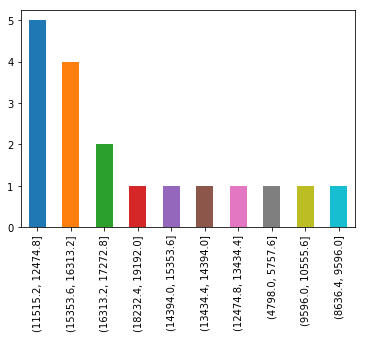

For Kilometrage of 150000 average price is 8804 and average year is 2011


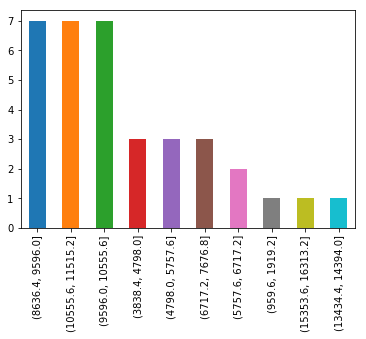

For Kilometrage of 200000 average price is 7340 and average year is 2010


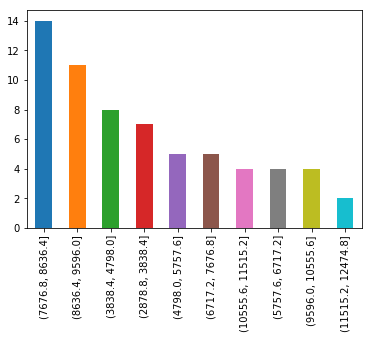

For Kilometrage of 250000 average price is 5634 and average year is 2008


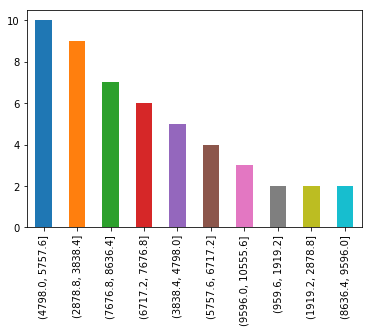

For Kilometrage of 500000 average price is 3603 and average year is 2006


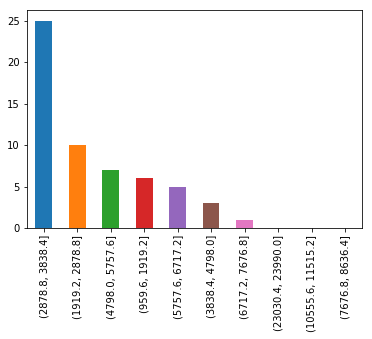

In [14]:
for km_range in sorted(list(df['KM_Ranges'].unique())):
    
    price_range = df[df['KM_Ranges'] == km_range]
    print('For Kilometrage of', km_range, 'average price is', 
          int(price_range['Price'].mean()),'and average year is',
          int(price_range['Year'].mean()))
    price_range['Price_range'].value_counts().iloc[0:10].plot.bar()
    plt.show()

The graphs above with 'automatic' ranges have horrible looking X axis!

<h1><font color='blue'>
Now lets do automatic market price estimator based on ML!</font></h1>

Because we have the data on used cars' market, we could start predicting the prices for cars, which are not on the market yet, to know how much would they cost if they were put to market. To do this, we need a model, capable of this. In particular case we can try ML (machine learning) algorithms, which have self-learning capabilities.

Before doing that we should check that the market data - which these algorithms will use to learn - is understood by them. As rule, they do not understand text data, which must be turned into digital (numeric) data.

Let's review our DataFrame and look at the table. We have DataFrame loking like this

In [16]:
df.head()

,Engine,kW,KM,Type,Drive,Year,Fuel,Transmission,Price,KM_Ranges,Price_range
No,,,,,,,,,,,
0,1.6,81,219000,luukpära,esivedu,1999,B,M,699,250000,"(-23.99, 959.6]"
1,1.8,81,260000,sedaan,esivedu,1999,B,M,990,500000,"(959.6, 1919.2]"
2,2.0,85,0,universaal,esivedu,2003,D,M,1050,50000,"(959.6, 1919.2]"
3,1.6,81,149000,sedaan,esivedu,2002,B,M,1199,150000,"(959.6, 1919.2]"
4,2.2,130,0,universaal,esivedu,2005,0,0,1400,50000,"(959.6, 1919.2]"


# Prepare DataFrame for ML

First, download the cars data again from the internet (if haven't done yet). This is the same DataFrame as above, but without added columns "KM_Ranges", "Price_range".

Second, let's see in which columns there we have "0" values. In particular case this is missing data.

In [5]:
contents1 = requests.get(link1)
contents2 = requests.get(link2)
df1 = get_cars(mark, contents1)
df2 = get_cars(mark, contents2)
df = df1.append(df2)

201 Downloaded 201 lines of car data for Toyota Avensis
94 Downloaded 94 lines of car data for Toyota Avensis


In [6]:
print('Now have DataFrame with data on',mark,'of',str(len(df)),'lines')

Now have DataFrame with data on Toyota Avensis of 294 lines


In [7]:
for column in df.columns:
    uniques = df[column].unique()
    if '0' in uniques:
        print('This colum has zero string values:','\t',column)
    if 0 in uniques:
        print('This colum has zero int values:','\t',column)

This colum has zero int values: 	 KM
This colum has zero int values: 	 Type
This colum has zero int values: 	 Drive
This colum has zero int values: 	 Fuel
This colum has zero int values: 	 Transmission
This colum has zero int values: 	 Price


What is the case with Price == 0?

In [8]:
df[df['Price'] == 0]

,Engine,kW,KM,Type,Drive,Year,Fuel,Transmission,Price
No,,,,,,,,,
93,1.8,108,0,sedaan,esivedu,2015,B,A,0


A singe row with Price == 0 will be removed

In [9]:
print('DataFrame on',mark,'before removal Price == 0 rows has lenght of',str(len(df)),'lines')
df = df[df['Price'] != 0]
print('DataFrame on',mark,'after removal Price == 0 rows has lenght of',str(len(df)),'lines')

DataFrame on Toyota Avensis before removal Price == 0 rows has lenght of 294 lines
DataFrame on Toyota Avensis after removal Price == 0 rows has lenght of 293 lines


For columns with "0" values identified above we create new columns having binary "0" or "1" values. They will have "dummy" in their names. This way the algorithms will have extra columns to learn.

In [10]:
columns = ['KM', 'Type', 'Drive', 'Fuel', 'Transmission']

ML_df = df.copy()
for column in columns:
    new_column = column + '_dummy'
    ML_df[new_column] = (df[column] == 0)
    print('Column',column,'has', len(ML_df[ML_df[new_column] == True]),'\t\tzero values')
print('We have transferred zeros in columns into new columns with binary values')

Column KM has 43 		zero values
Column Type has 31 		zero values
Column Drive has 32 		zero values
Column Fuel has 6 		zero values
Column Transmission has 6 		zero values
We have transferred zeros in columns into new columns with binary values


In [11]:
print('Example of dummy columns == True')
ML_df[ML_df['Type'] == 0][0:2]

Example of dummy columns == True


,Engine,kW,KM,Type,Drive,Year,Fuel,Transmission,Price,KM_dummy,Type_dummy,Drive_dummy,Fuel_dummy,Transmission_dummy
No,,,,,,,,,,,,,,
106,2.2,110,0,0,0,2009,D,M,5300,True,True,True,False,False
181,2.0,112,0,0,0,2011,B,A,8799,True,True,True,False,False


Columns:

Engine,	kW,	Type,	Drive,	Year,	Fuel,	Transmission 

have text data or data, which is numeric, but does not have meaning as numeric data.

These columns will be transferred to simple integer values. So, the earliest year (be it 1999, for example) will become "1", the next year after that (2000) will become "2" etc

In [12]:
columns = ['Engine', 'kW', 'Year']
mappings = []

for column in sorted(list(columns)):

    d = {}
    i = 1
    for value in sorted(list(ML_df[column].unique())):
        d[value] = i
        i += 1
    
    mappings.append(d)

    ML_df[column] = ML_df[column].map(d)

columns = ['Type', 'Drive', 'Fuel', 'Transmission']

for column in sorted(list(columns)):

    d = {}
    i = 1
    for value in ML_df[column].unique():
        d[value] = i
        i += 1
    
    mappings.append(d)

    ML_df[column] = ML_df[column].map(d)

Now the DataFrame is prepared and looks like this. The original numeric data left is only KM (one of features) and Price (the target variable)

In [13]:
ML_df.head()

,Engine,kW,KM,Type,Drive,Year,Fuel,Transmission,Price,KM_dummy,Type_dummy,Drive_dummy,Fuel_dummy,Transmission_dummy
No,,,,,,,,,,,,,,
0,1,2,0,1,1,2,1,1,590,True,False,False,False,False
1,1,2,219000,2,1,1,1,1,699,False,False,False,False,False
2,2,2,260000,1,1,1,1,1,990,False,False,False,False,False
3,3,4,0,3,1,3,2,1,1050,True,False,False,False,False
4,1,2,149000,1,1,2,1,1,1199,False,False,False,False,False


In [14]:
features = list(ML_df.columns)
features.remove('Price')
print('Our ML model has the following features:\n',features)

Our ML model has the following features:
 ['Engine', 'kW', 'KM', 'Type', 'Drive', 'Year', 'Fuel', 'Transmission', 'KM_dummy', 'Type_dummy', 'Drive_dummy', 'Fuel_dummy', 'Transmission_dummy']


We split the data into three (very small) datasets. One for training, another for testing and the third one for final validation. To split, a module called  "train_test_split" is used.

In [31]:
from sklearn.model_selection import train_test_split

x, X_test, y, y_test = train_test_split(ML_df[features],ML_df['Price'],test_size=0.2,train_size=0.8)
X_train, X_validate, y_train, y_validate = train_test_split(x,y,test_size = 0.15,train_size =0.85)

print('Train dataset:', len(X_train), 'Test dataset:', len(X_test), 'Validation dataset:', len(X_validate))

Train dataset: 198 Test dataset: 59 Validation dataset: 36


# Now let's prepare various regression ML algoritms

Below is a selection of ML regression algorithms, which can be considered for car predictions. These regression models are used in test scenario here with their default or suggested hyperparametres, no specific parametre tuning has been done

In [32]:
KN = KNeighborsRegressor(n_neighbors=2).fit(X_train,y_train)
print('KNeighbors Regression R2 is:\t\t','%.3f' %KN.score(X_test,y_test))

reg = LinearRegression().fit(X_train, y_train)
print('Linear Regression R2 is:\t','%.3f' %reg.score(X_test,y_test))

ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
print('Ridge Regression R2 is:\t\t','%.3f' %ridge.score(X_test,y_test))

lasso = linear_model.Lasso(alpha=0.1).fit(X_train,y_train)
print('Lasso Regression R2 is:\t\t','%.3f' %lasso.score(X_test,y_test))

tree = DecisionTreeRegressor(max_depth=5).fit(X_train,y_train)
print('Decision Tree Regression R2 is:\t\t','%.3f' %tree.score(X_test,y_test))

forest = RandomForestRegressor(max_depth = 5, n_estimators=100).fit(X_train, y_train)
print('Random Forest Regression R2 is:\t','%.3f' %forest.score(X_test,y_test))

params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gradient = GradientBoostingRegressor(**params).fit(X_train,y_train)
print('Gredient Boost Regression R2 is:\t','%.3f' %gradient.score(X_test,y_test))

KNeighbors Regression R2 is:		 0.766
Linear Regression R2 is:	 0.930
Ridge Regression R2 is:		 0.930
Lasso Regression R2 is:		 0.930
Decision Tree Regression R2 is:		 0.952
Random Forest Regression R2 is:	 0.964
Gredient Boost Regression R2 is:	 0.965


These regression ML algorithms produce different R2, with R2 of Gradient Boosting the highest. R2 is not too ideal for understanding the value of these models and determining which of them is the best, so Mean Absolute Error is used over test set

In [33]:
from sklearn.metrics import mean_absolute_error

print('KN MAE:\t\t','%.2f' %mean_absolute_error(y_test,KN.predict(X_test[features])))
print('Linear MAE:\t','%.2f' %mean_absolute_error(y_test, reg.predict(X_test[features])))
print('Ridge MAE:\t','%.2f' %mean_absolute_error(y_test, ridge.predict(X_test[features])))
print('Lasso MAE:\t','%.2f' %mean_absolute_error(y_test, lasso.predict(X_test[features])))
print('Tree MAE:\t','%.2f' %mean_absolute_error(y_test, tree.predict(X_test[features])))
print('Forest MAE:\t','%.2f' %mean_absolute_error(y_test, forest.predict(X_test[features])))
print('Gradient MAE:\t','%.2f' %mean_absolute_error(y_test, gradient.predict(X_test[features])))

KN MAE:		 2093.56
Linear MAE:	 1119.37
Ridge MAE:	 1126.47
Lasso MAE:	 1118.78
Tree MAE:	 957.51
Forest MAE:	 787.06
Gradient MAE:	 787.67


Gradient Boosting and Random Forest give the smallest average error of predicted "Price" over the test set. Following is an example of prices predicted by Linear regression and by Gradient Boosting. First, simplest Linear regression is calculated and difference between actual and predicted price is displayed for 10 cars in test set.

In [34]:
for price_predicted, price_real in zip(reg.predict(X_test[features])[0:10], y_test[0:10]):
    print('Lin. regression price:',int(price_predicted), 
          '\t Real Price:',price_real, 
          '\t Difference:',abs(int(price_predicted) - price_real))

Lin. regression price: -368 	 Real Price: 699 	 Difference: 1067
Lin. regression price: 7139 	 Real Price: 7500 	 Difference: 361
Lin. regression price: 16851 	 Real Price: 16990 	 Difference: 139
Lin. regression price: 594 	 Real Price: 2900 	 Difference: 2306
Lin. regression price: 13748 	 Real Price: 11990 	 Difference: 1758
Lin. regression price: 7331 	 Real Price: 7250 	 Difference: 81
Lin. regression price: 13630 	 Real Price: 12000 	 Difference: 1630
Lin. regression price: 10227 	 Real Price: 10999 	 Difference: 772
Lin. regression price: 12415 	 Real Price: 10700 	 Difference: 1715
Lin. regression price: 3559 	 Real Price: 4490 	 Difference: 931


Second, basic Gradient Boosting regression is calculated and difference between actual and predicted price is displayed.

In [35]:
for price_predicted, price_real in zip(gradient.predict(X_test[features])[0:10], y_test[0:10]):
    print('Gradient price:',int(price_predicted), 
          '\t Real Price:',price_real, 
          '\t Difference:',abs(int(price_predicted) - price_real))

Gradient price: 1018 	 Real Price: 699 	 Difference: 319
Gradient price: 6806 	 Real Price: 7500 	 Difference: 694
Gradient price: 17661 	 Real Price: 16990 	 Difference: 671
Gradient price: 2458 	 Real Price: 2900 	 Difference: 442
Gradient price: 12973 	 Real Price: 11990 	 Difference: 983
Gradient price: 6473 	 Real Price: 7250 	 Difference: 777
Gradient price: 13215 	 Real Price: 12000 	 Difference: 1215
Gradient price: 9984 	 Real Price: 10999 	 Difference: 1015
Gradient price: 10882 	 Real Price: 10700 	 Difference: 182
Gradient price: 3734 	 Real Price: 4490 	 Difference: 756


Gradient Boosting regression wins in both R2 and MAE terms. The differences between predicted and actual prices are also smaller than for Linear regression. Can it be further optimized with hyperparametre optimization? Following code tries to optimize, somewhat, the hyperparametres.

In [36]:
nn_estimators = [500, 600, 700]
max_depths = [3, 4, 5, 6]
min_samples_splits = [2, 3, 4]
learning_rate = [0.01, 0.015, 0.02, 0.03]

i = 0
for n in nn_estimators:
    for d in max_depths:
        for s in min_samples_splits:
            for l in learning_rate:
                gradient = GradientBoostingRegressor(n_estimators = n,
                                                     max_depth = d,
                                                     min_samples_split = s,
                                                     learning_rate = l,
                                                    ).fit(X_train,y_train)
                if i == 0:
                    best_train_r2 = gradient.score(X_train,y_train)
                    best_test_r2 = gradient.score(X_test,y_test)
                else:
                    current_train_r2 = gradient.score(X_train,y_train)
                    current_test_r2 = gradient.score(X_test,y_test)
                    if current_test_r2 > best_test_r2:
                        best_test_r2 = current_test_r2
                        print(str(i),
                              'n_estimators =', n,
                             'max_depth = ',d,
                             'min_samples = ',s,
                             'learning_rate = ', l,
                             'Test R2 = ', '%.4f' %best_test_r2)
                i += 1
print('Optimization cycle completed at i =',str(i))

4 n_estimators = 500 max_depth =  3 min_samples =  3 learning_rate =  0.01 Test R2 =  0.9692
8 n_estimators = 500 max_depth =  3 min_samples =  4 learning_rate =  0.01 Test R2 =  0.9692
Optimization cycle completed at i = 144


The above optimization found better hyperparametres leading to higher R2. We set Gradient Boosting with those parametres

In [37]:
opt_params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 4,
          'learning_rate': 0.01, 'loss': 'ls'}

opt_gradient = GradientBoostingRegressor(**opt_params).fit(X_train,y_train)

for f,i in zip(X_train.columns, opt_gradient.feature_importances_):
    print(f,'\t','%.4f' %i)

Engine 	 0.0009
kW 	 0.0020
KM 	 0.0312
Type 	 0.0004
Drive 	 0.0001
Year 	 0.9599
Fuel 	 0.0011
Transmission 	 0.0031
KM_dummy 	 0.0009
Type_dummy 	 0.0002
Drive_dummy 	 0.0001
Fuel_dummy 	 0.0000
Transmission_dummy 	 0.0000


We stop here having an improvement over Linear Regression
# Gradient Boosting's results

Optimized Gradient Boost regression has MAE of

In [38]:
print('Oprtimized Gradient MAE:\t',
      '%.2f' %mean_absolute_error(y_test, opt_gradient.predict(X_test[features])))

Oprtimized Gradient MAE:	 740.73


This is the smallest price difference yet. We also have validation set. How much better is this somewhat optimized Gradient Boosting over Linear Regression?

In [39]:
print('Oprtimized Gradient MAE:\t',
      '%.2f' %mean_absolute_error(y_validate, opt_gradient.predict(X_validate[features])))
print('Standard Regression MAE:\t',
      '%.2f' %mean_absolute_error(y_validate, reg.predict(X_validate[features])))

Oprtimized Gradient MAE:	 816.60
Standard Regression MAE:	 1403.68


In [41]:
for price_predicted, price_real in zip(opt_gradient.predict(X_validate)[0:10], y_validate):
    print('Optimized Gradient Boost price:',int(price_predicted), 
          '\t Real Price:',price_real, 
          '\t Difference:',abs(int(price_predicted) - price_real))

Optimized Gradient Boost price: 6907 	 Real Price: 7690 	 Difference: 783
Optimized Gradient Boost price: 4118 	 Real Price: 3990 	 Difference: 128
Optimized Gradient Boost price: 12969 	 Real Price: 9950 	 Difference: 3019
Optimized Gradient Boost price: 9301 	 Real Price: 6990 	 Difference: 2311
Optimized Gradient Boost price: 8774 	 Real Price: 8490 	 Difference: 284
Optimized Gradient Boost price: 6523 	 Real Price: 5900 	 Difference: 623
Optimized Gradient Boost price: 10810 	 Real Price: 9900 	 Difference: 910
Optimized Gradient Boost price: 7527 	 Real Price: 8100 	 Difference: 573
Optimized Gradient Boost price: 6640 	 Real Price: 5700 	 Difference: 940
Optimized Gradient Boost price: 13732 	 Real Price: 13699 	 Difference: 33


In [42]:
for price_predicted, price_real in zip(reg.predict(X_validate)[0:10], y_validate):
    print('Lin. Regression price:',int(price_predicted), 
          '\t\t Real Price:',price_real, 
          '\t Difference:',abs(int(price_predicted) - price_real))

Lin. Regression price: 7929 		 Real Price: 7690 	 Difference: 239
Lin. Regression price: 4637 		 Real Price: 3990 	 Difference: 647
Lin. Regression price: 14191 		 Real Price: 9950 	 Difference: 4241
Lin. Regression price: 10918 		 Real Price: 6990 	 Difference: 3928
Lin. Regression price: 10596 		 Real Price: 8490 	 Difference: 2106
Lin. Regression price: 7572 		 Real Price: 5900 	 Difference: 1672
Lin. Regression price: 10626 		 Real Price: 9900 	 Difference: 726
Lin. Regression price: 8609 		 Real Price: 8100 	 Difference: 509
Lin. Regression price: 7312 		 Real Price: 5700 	 Difference: 1612
Lin. Regression price: 13295 		 Real Price: 13699 	 Difference: 404


Gradint Boosting errors less in predicting prices, making prices predicted closer to market prices. Because validation set was used, this is considered sufficient proof. 

# Predict price of a car

Now let's predict a car price using 'mappings' (see above) to encode a DataFrame with car's parametres and use optimized Gradient Boosting regression as predictor.
I enter the cars characteristics and then predict that this 2017 car's price is 20K!

Below, entries about our car are made into DataFrame. These entries are encoded. For example car "Transmission" (gear box) is encoded to "3" when gear box is Automatic.The only unencoded value is KM (21 thousand kilometres)

In [59]:
my_car = pd.DataFrame(columns = ML_df.columns, index = range(0,1))
my_car.Engine[0:1] = 2
my_car.kW[0:1] = 11
my_car.KM[0:1] = 21000
my_car.Type[0:1] = 1
my_car.Drive[0:1] = 1
my_car.Year[0:1] = 17
my_car.Fuel[0:1] = 1
my_car.Transmission[0:1] = 3
my_car.KM_dummy[0:1] = False
my_car.Type_dummy[0:1] = False
my_car.Drive_dummy[0:1] = False
my_car.Fuel_dummy[0:1] = False
my_car.Transmission_dummy[0:1] = False

In [60]:
print('This 2017 Toyota Avensis price is:')
int(opt_gradient.predict(my_car[features])[0]),'EUR'

This 2017 Toyota Avensis price is:


(20186, 'EUR')